# Stanford CME 241 (Winter 2026) - Assignment 2

**Due: Friday, February 13 @ 11:59 PM PST on Gradescope.**

Assignment instructions:
- Make sure each of the subquestions have answers
- Ensure that group members indicate which problems they're in charge of
- Show work and walk through your thought process where applicable
- Empty code blocks are for your use, so feel free to create more under each section as needed
- Document code with light comments (i.e. 'this function handles visualization')

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):*

https://github.com/UniversalDreams/RL-book/tree/master/assignments

*Group members (replace below names with people in your group):*
- Person 1
- Person 2
- Person 3

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Question 1: Job-Hopping and Wages-Utility-Maximization (Led by ______)

You are a worker who starts every day either employed or unemployed. If you start your day employed, you work on your job for the day (one of $n$ jobs, as elaborated later) and you get to earn the wage of the job for the day. However, at the end of the day, you could lose your job with probability $\alpha \in [0,1]$, in which case you start the next day unemployed. If at the end of the day, you do not lose your job (with probability $1-\alpha$), then you will start the next day with the same job (and hence, the same daily wage).

On the other hand, if you start your day unemployed, then you will be randomly offered one of $n$ jobs with daily wages $w_1, w_2, \ldots w_n \in \mathbb{R}^+$ with respective job-offer probabilities $p_1, p_2, \ldots p_n \in [0,1]$ (with $\sum_{i=1}^n p_i = 1$). You can choose to either accept or decline the offered job. If you accept the job offer, your day progresses exactly like the **employed-day** described above (earning the day's job wage and possibly (with probability $\alpha$) losing the job at the end of the day). However, if you decline the job offer, you spend the day unemployed, receive the unemployment wage $w_0 \in \mathbb{R}^+$ for the day, and start the next day unemployed.

The problem is to identify the optimal choice of accepting or rejecting any of the job offers the worker receives, in a manner that maximizes the infinite-horizon **Expected Discounted-Sum of Wages Utility**. Assume the daily discount factor for wages (employed or unemployed) is $\gamma \in [0,1])$. Assume Wages Utility function to be $U(w) = \log(w)$ for any wage amount $w \in \mathbb{R}^+$. The goal is to maximize:

$$
\mathbb{E}\left[\sum_{u=t}^\infty \gamma^{u-t} \cdot \log(w_{i_u})\right]
$$

at the start of a given day $t$ ($w_{i_u}$ is the wage earned on day $u$, $0 \leq i_u \leq n$ for all $u \geq t$).

---

### Subquestions

#### Part (A): MDP Modeling

Express the job-hopping problem as an MDP using clear mathematical notation by defining the following components:

1. **State Space**: Define the possible states of the MDP.
2. **Action Space**: Specify the actions available to the worker at each state.
3. **Transition Function**: Describe the probabilities of transitioning between states for each action.
4. **Reward Function**: Specify the reward associated with the states and transitions.
5. **Bellman Optimality Equation**: Write the Bellman Optimality Equation customized for this MDP.

---

#### Part (B): Python Implementation

Write Python code that:

1. Solves the Bellman Optimality Equation (hence, solves for the **Optimal Value Function** and the **Optimal Policy**) with a numerical iterative algorithm.
2. Clearly define the inputs and outputs of your algorithm with their types (`int`, `float`, `List`, `Mapping`, etc.).

*Note*: For this problem, write the algorithm from scratch without using any prebuilt MDP/DP libraries or code.

---

#### Part (C): Visualization and Analysis

1. Plot the **Optimal Value Function** as a function of the state for a specific set of parameters ($n$, $w_1, \ldots, w_n$, $p_1, \ldots, p_n$, $\alpha$, $\gamma$, $w_0$).
2. Include these graphs in your submission.

---

#### Part (D): Observations

1. What patterns do you observe in the **Optimal Policy** as you vary the parameters $n$, $\alpha$, and $\gamma$?
2. Provide a brief discussion of your findings.

---

### Part (A) Answer

<span style="color:red">**State Space** $s = (u, w_i)$: Unemployed, with a current job offer of wage $w_i$.

$s = (e, w_j)$ : Employed, currently earning daily wage $w_j$.
\
\
**Action Space**:
$A(u, w_i) = \{ \text{Accept, Decline} \}$ and $A(e, w_j) = \{ \text{Stay} \}$
\
\
**Reward Function**:
$R((u, w_i), \text{Decline}) = \log(w_0)$

$R((u, w_i), \text{Accept}) = \log(w_i)$

$R((e, w_j), \text{Stay}) = \log(w_j)$
\
\
**Transition Probabilities**

$P((u, w_k) \mid (u, w_i), \text{Decline}) = p_k$

$P((e, w_i) \mid s, a) = 1 - \alpha$

$P((u, w_k) \mid s, a) = \alpha \cdot p_k$
\
\
**Bellman Optimality Equation**

$$V(e, w_i) = \log(w_i) + \gamma \left[ (1 - \alpha) V(e, w_i) + \alpha \sum_{k=1}^n p_k V(u, w_k) \right]$$$$V(u, w_i) = \max \begin{cases} \log(w_0) + \gamma \sum_{k=1}^n p_k V(u, w_k) & \text{(Decline)} \\ V(e,w_i)\text {(Accept)} \end{cases}$$
</span>

### Part (B) Answer

In [ ]:
import math

def solve_job_hopping(w_0, w_offers, p_offers, alpha, gamma, epsilon=1e-8):
    # Initialize Value Functions
    # V_u[w] is the value of being unemployed and having an offer w
    # V_e[w] is the value of being employed at wage w
    V_u = {w: 0.0 for w in w_offers}
    V_e = {w: 0.0 for w in w_offers}
    policy = {w: "" for w in w_offers}

    # Pre-calculate log utilities
    u_0 = math.log(w_0)
    u_w = {w: math.log(w) for w in w_offers}

    iteration = 0
    while True:
        delta = 0
        new_V_u = {}
        new_V_e = {}

        # Calculate the expected future value if unemployed tomorrow
        # This term (Sum of p_k * V_u(k)) appears in every transition
        expected_V_unemployed = sum(p * V_u[w] for p, w in zip(p_offers, w_offers))

        for w in w_offers:
            # --- 1. Update Employed Value V_e(w) ---
            # Reward + gamma * [(Keep Job) + (Lose Job)]
            val_e = u_w[w] + gamma * ((1 - alpha) * V_e[w] + alpha * expected_V_unemployed)
            new_V_e[w] = val_e

            # --- 2. Update Unemployed Value V_u(w) ---
            # Option: Decline
            v_decline = u_0 + gamma * expected_V_unemployed

            # Option: Accept (Enter the employment cycle)
            v_accept = u_w[w] + gamma * ((1 - alpha) * V_e[w] + alpha * expected_V_unemployed)

            # Bellman Optimality: Maximize over actions
            if v_accept >= v_decline:
                new_V_u[w] = v_accept
                policy[w] = "Accept"
            else:
                new_V_u[w] = v_decline
                policy[w] = "Decline"

            # Track maximum change for convergence
            delta = max(delta, abs(new_V_u[w] - V_u[w]), abs(new_V_e[w] - V_e[w]))

        V_u, V_e = new_V_u, new_V_e
        iteration += 1

        if delta < epsilon:
            break

    return V_u, V_e, policy

# --- Example Usage ---
w_0 = 10.0
w_list = [15.0, 20.0, 30.0, 50.0]
p_list = [0.4, 0.3, 0.2, 0.1]
alpha = 0.1  # 10% chance to lose job
gamma = 0.95 # Discount factor

v_u, v_e, opt_policy = solve_job_hopping(w_0, w_list, p_list, alpha, gamma)

print("Wage | Policy  | Value (Unemployed)")
print("-" * 35)
for w in w_list:
    print(f"{w:4} | {opt_policy[w]:7} | {v_u[w]:.4f}")

Wage | Policy  | Value (Unemployed)
-----------------------------------
15.0 | Decline | 64.0658
20.0 | Decline | 64.0658
30.0 | Accept  | 66.0519
50.0 | Accept  | 69.5748


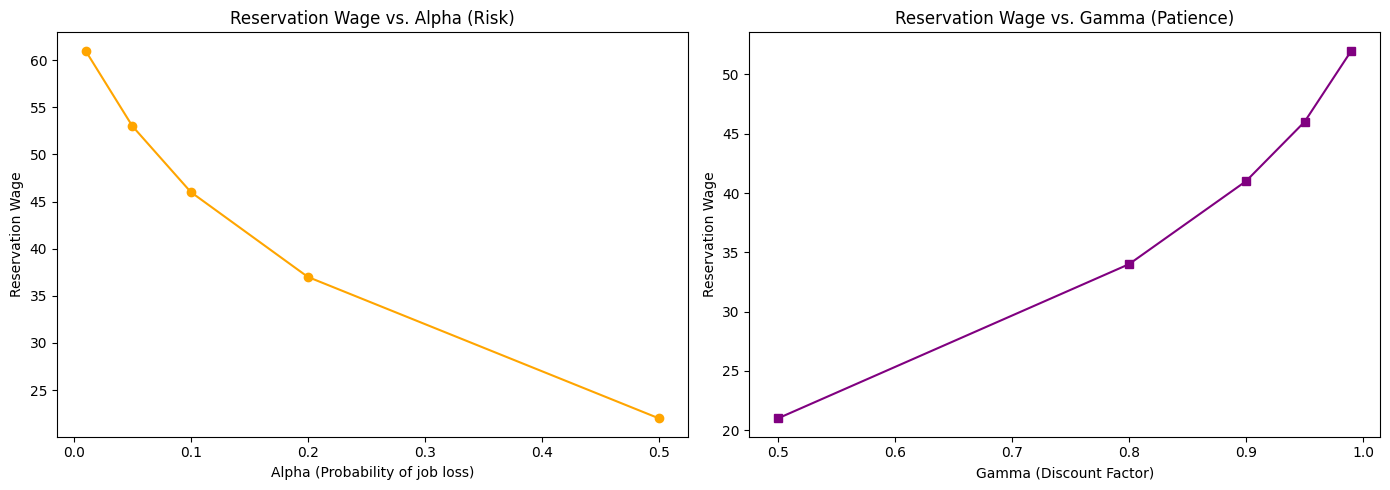

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_reservation_wage(w_0, w_offers, p_offers, alpha, gamma):
    """Returns the minimum wage the worker is willing to accept."""
    _, _, policy = solve_job_hopping(w_0, w_offers, p_offers, alpha, gamma)
    accepted_wages = [w for w, action in policy.items() if action == "Accept"]
    return min(accepted_wages) if accepted_wages else max(w_offers)

# Parameters
w_0 = 10.0
w_offers = np.arange(10, 100, 1).tolist()
p_offers = [1/len(w_offers)] * len(w_offers)

# 1. Varying Alpha (Risk of Job Loss)
alphas = [0.01, 0.05, 0.1, 0.2, 0.5]
res_wages_alpha = [get_reservation_wage(w_0, w_offers, p_offers, a, 0.95) for a in alphas]

# 2. Varying Gamma (Patience/Discounting)
gammas = [0.5, 0.8, 0.9, 0.95, 0.99]
res_wages_gamma = [get_reservation_wage(w_0, w_offers, p_offers, 0.1, g) for g in gammas]

# Plotting Results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(alphas, res_wages_alpha, marker='o', color='orange')
ax1.set_title('Reservation Wage vs. Alpha (Risk)')
ax1.set_xlabel('Alpha (Probability of job loss)')
ax1.set_ylabel('Reservation Wage')

ax2.plot(gammas, res_wages_gamma, marker='s', color='purple')
ax2.set_title('Reservation Wage vs. Gamma (Patience)')
ax2.set_xlabel('Gamma (Discount Factor)')
ax2.set_ylabel('Reservation Wage')

plt.tight_layout()
plt.show()

### Part (D) Answer

<span style="color:red">An increase in alpha with a low discount rate will lead to an overall decrease in wage over time as n increases. This is because we are following a greedy approach such that we are trying to find the best wage, without considering for the future. On the hand, when our discount factor is near 1, we care about the future, such that within an assumed infinite horizon, where n increases, we will find a more optimal solution compared to the latter.</span>

## Question 2: Two-Stores Inventory Control (Led by ______)

We extend the capacity-constrained inventory example implemented in [rl/chapter3/simple_inventory_mdp_cap.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter3/simple_inventory_mdp_cap.py) as a `FiniteMarkovDecisionProcess` (the Finite MDP model for the capacity-constrained inventory example is described in detail in Chapters 1 and 2 of the RLForFinanceBook). Here we assume that we have two different stores, each with their own separate capacities $C_1$ and $C_2$, their own separate Poisson probability distributions of demand (with means $\lambda_1$ and $\lambda_2$), their own separate holding costs $h_1$ and $h_2$, and their own separate stockout costs $p_1$ and $p_2$. At 6pm upon stores closing each evening, each store can choose to order inventory from a common supplier (as usual, ordered inventory will arrive at the store 36 hours later). We are also allowed to transfer inventory from one store to another, and any such transfer happens overnight, i.e., will arrive by 6am next morning (since the stores are fairly close to each other). Note that the orders are constrained such that following the orders on each evening, each store's inventory position (sum of on-hand inventory and on-order inventory) cannot exceed the store's capacity (this means the action space is constrained to be finite). Each order made to the supplier incurs a fixed transportation cost of $K_1$ (fixed-cost means the cost is the same no matter how many units of non-zero inventory a particular store orders). Moving any non-zero inventory between the two stores incurs a fixed transportation cost of $K_2$.

Model this as a derived class of `FiniteMarkovDecisionProcess` much like we did for `SimpleInventoryMDPCap` in the code repo. Set up instances of this derived class for different choices of the problem parameters (capacities, costs etc.), and determine the Optimal Value Function and Optimal Policy by invoking the function `value_iteration` (or `policy_iteration`) from file [rl/dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/dynamic_programming.py).

Analyze the obtained Optimal Policy and verify that it makes intuitive sense as a function of the problem parameters.

In [9]:
import sys
import os
if '/content/RL-book' not in sys.path:
    sys.path.append('/content/RL-book')

from dataclasses import dataclass
from typing import Tuple, Dict, Mapping
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.distribution import Categorical
from rl.dynamic_programming import value_iteration_result
from scipy.stats import poisson
import numpy as np

@dataclass(frozen=True)
class TwoStoreState:
    inv1: int  # Store 1 On-hand
    ord1: int  # Store 1 On-order
    inv2: int  # Store 2 On-hand
    ord2: int  # Store 2 On-order

    def inventory_position(self, store_idx: int) -> int:
        if store_idx == 1:
            return self.inv1 + self.ord1
        return self.inv2 + self.ord2

# Action: (order1, order2, transfer)
# transfer > 0: Store 1 -> Store 2
# transfer < 0: Store 2 -> Store 1
Action = Tuple[int, int, int]

class TwoStoreInventoryMDP(FiniteMarkovDecisionProcess[TwoStoreState, Action]):
    def __init__(
        self,
        capacity1: int,
        capacity2: int,
        lambda1: float,
        lambda2: float,
        holding_cost1: float,
        holding_cost2: float,
        stockout_cost1: float,
        stockout_cost2: float,
        order_fixed_cost: float,
        transfer_fixed_cost: float
    ):
        self.c1 = capacity1
        self.c2 = capacity2
        self.lam1 = lambda1
        self.lam2 = lambda2
        self.h1 = holding_cost1
        self.h2 = holding_cost2
        self.p1 = stockout_cost1
        self.p2 = stockout_cost2
        self.k1 = order_fixed_cost
        self.k2 = transfer_fixed_cost

        self.pois1 = poisson(lambda1)
        self.pois2 = poisson(lambda2)

        super().__init__(self.get_action_transition_reward_map())

    def get_action_transition_reward_map(self) -> Mapping[TwoStoreState, Mapping[Action, Categorical[Tuple[TwoStoreState, float]]]]:
        d = {}

        # Generate all valid states
        states = []
        for i1 in range(self.c1 + 1):
            for o1 in range(self.c1 - i1 + 1):
                for i2 in range(self.c2 + 1):
                    for o2 in range(self.c2 - i2 + 1):
                        states.append(TwoStoreState(i1, o1, i2, o2))

        for state in states:
            d[state] = {}

            # Valid Transfers: constrained by on-hand inventory
            # Range: -inv2 (all from 2 to 1) to +inv1 (all from 1 to 2)
            min_transfer = -state.inv2
            max_transfer = state.inv1

            for t in range(min_transfer, max_transfer + 1):
                # Effective Inventory after transfer (available for demand)
                eff_inv1 = state.inv1 + state.ord1 - t
                eff_inv2 = state.inv2 + state.ord2 + t

                # Valid Orders: IP + Order <= Capacity
                # IP here includes the effective inventory plus the new order
                max_order1 = self.c1 - eff_inv1
                max_order2 = self.c2 - eff_inv2

                for u1 in range(max_order1 + 1):
                    for u2 in range(max_order2 + 1):
                        action = (u1, u2, t)

                        # Calculate deterministic costs (immediate negative reward)
                        cost = 0.0
                        cost += self.h1 * state.inv1 + self.h2 * state.inv2
                        if u1 > 0: cost += self.k1
                        if u2 > 0: cost += self.k1
                        if t != 0: cost += self.k2

                        base_reward = -cost

                        # Transitions based on Demand (d1, d2)
                        # S1 = state.inv1 + state.ord1 - t (Available for demand at 1)
                        # S2 = state.inv2 + state.ord2 + t (Available for demand at 2)
                        # Note: Transfer arrives 6am. 'ord' arrived 6am.
                        # So available for Day T demand is (inv + ord +/- t).
                        S1 = state.inv1 + state.ord1 - t
                        S2 = state.inv2 + state.ord2 + t

                        # Pre-calculate stockout costs and probabilities
                        # Expected Shortage cost logic from SimpleInventoryMDPCap
                        # For Store 1:
                        prob_sat1 = self.pois1.cdf(S1 - 1) if S1 > 0 else 0.0 # P(D < S1)
                        prob_out1 = 1.0 - prob_sat1 # P(D >= S1)

                        # Expected shortage given stockout: E[(D-S1)^+] / P(D>=S1)
                        # Contribution to cost = P(D>=S1) * p1 * (E[...] / P) = p1 * E[(D-S1)^+]
                        # E[(D-S)+] = lambda * (1 - F(S-1)) - S * (1 - F(S))
                        # F(x) is cdf at x.
                        # If S=0, E[D] = lambda.

                        exp_shortage1 = self.lam1 - S1 # Default if S1=0 and we always stockout?
                        if S1 > 0:
                             exp_shortage1 = self.lam1 * (1 - self.pois1.cdf(S1-1)) - S1 * (1 - self.pois1.cdf(S1))
                        elif S1 == 0:
                             exp_shortage1 = self.lam1 # E[D]

                        # Wait, SimpleInventoryMDPCap applies the specific reward to the stockout state transition.
                        # We need to distribute this over transitions.

                        # Building the categorical distribution
                        next_state_probs = {}

                        # Loop over demands. Since capacity is small, we can iterate until prob is negligible or just cover 0..S
                        # SimpleInventoryMDPCap iterates 0..ip and puts the rest in 0.

                        for d1 in range(S1 + 1):
                            p_d1 = self.pois1.pmf(d1) if d1 < S1 else (1 - self.pois1.cdf(S1 - 1))

                            reward_d1 = 0.0
                            # If d1 == S1 (representing >= S1), add stockout cost
                            if d1 == S1:
                                # Correct stockout cost calculation for the 'tail' transition
                                # Cost = p1 * (Expected Shortage)
                                # Wait, we must assign the *conditional* expected stockout cost to this transition.
                                # Reward -= p1 * (E[Shortage] / P(D>=S1))
                                if p_d1 > 1e-9:
                                    reward_d1 -= self.p1 * (exp_shortage1 / p_d1)

                            remaining1 = S1 - d1 if d1 < S1 else 0

                            for d2 in range(S2 + 1):
                                p_d2 = self.pois2.pmf(d2) if d2 < S2 else (1 - self.pois2.cdf(S2 - 1))

                                reward_d2 = 0.0
                                if d2 == S2:
                                    # Calculate expected shortage for store 2
                                    exp_shortage2 = self.lam2 # S2=0 case
                                    if S2 > 0:
                                        exp_shortage2 = self.lam2 * (1 - self.pois2.cdf(S2-1)) - S2 * (1 - self.pois2.cdf(S2))

                                    if p_d2 > 1e-9:
                                        reward_d2 -= self.p2 * (exp_shortage2 / p_d2)

                                total_reward = base_reward + reward_d1 + reward_d2
                                remaining2 = S2 - d2 if d2 < S2 else 0

                                next_s = TwoStoreState(remaining1, u1, remaining2, u2)
                                prob = p_d1 * p_d2

                                if prob > 0:
                                    if (next_s, total_reward) in next_state_probs:
                                        next_state_probs[(next_s, total_reward)] += prob
                                    else:
                                        next_state_probs[(next_s, total_reward)] = prob

                        d[state][action] = Categorical(next_state_probs)
        return d

# --- Instantiate and Solve ---
C = 3 # Small capacity for demo
print(f"Solving for Capacity C1=C2={C}...")

mdp = TwoStoreInventoryMDP(
    capacity1=C, capacity2=C,
    lambda1=1.0, lambda2=1.5,
    holding_cost1=1.0, holding_cost2=1.0,
    stockout_cost1=10.0, stockout_cost2=10.0,
    order_fixed_cost=5.0,
    transfer_fixed_cost=2.0
)

gamma = 0.9
opt_vf, opt_policy = value_iteration_result(mdp, gamma=gamma)

print("\nOptimal Value Function (Sample):")
# Print a few states
for s in list(opt_vf.keys())[:5]:
    print(f"State {s}: {opt_vf[s]:.2f}")

print("\nOptimal Policy Analysis:")
print("Format: State -> Action (Order1, Order2, Transfer)")

# Scenario 1: Store 1 full, Store 2 empty
s1 = TwoStoreState(C, 0, 0, 0)
if s1 in opt_policy.policy_map:
    print(f"Store 1 Full, Store 2 Empty {s1}: {opt_policy.policy_map[s1]}")

# Scenario 2: Both empty
s2 = TwoStoreState(0, 0, 0, 0)
if s2 in opt_policy.policy_map:
    print(f"Both Empty {s2}: {opt_policy.policy_map[s2]}")

# Scenario 3: Store 1 empty, Store 2 full
s3 = TwoStoreState(0, 0, C, 0)
if s3 in opt_policy.policy_map:
    print(f"Store 1 Empty, Store 2 Full {s3}: {opt_policy.policy_map[s3]}")

# Scenario 4: Both full
s4 = TwoStoreState(C, 0, C, 0)
if s4 in opt_policy.policy_map:
    print(f"Both Full {s4}: {opt_policy.policy_map[s4]}")


Solving for Capacity C1=C2=3...

Optimal Value Function (Sample):
State NonTerminal(state=TwoStoreState(inv1=0, ord1=0, inv2=0, ord2=0)): -144.36
State NonTerminal(state=TwoStoreState(inv1=0, ord1=0, inv2=0, ord2=1)): -139.69
State NonTerminal(state=TwoStoreState(inv1=0, ord1=0, inv2=0, ord2=2)): -136.06
State NonTerminal(state=TwoStoreState(inv1=0, ord1=0, inv2=0, ord2=3)): -131.87
State NonTerminal(state=TwoStoreState(inv1=0, ord1=0, inv2=1, ord2=0)): -140.69

Optimal Policy Analysis:
Format: State -> Action (Order1, Order2, Transfer)
Store 1 Full, Store 2 Empty TwoStoreState(inv1=3, ord1=0, inv2=0, ord2=0): Constant(value=(2, 0, 2))
Both Empty TwoStoreState(inv1=0, ord1=0, inv2=0, ord2=0): Constant(value=(3, 3, 0))
Store 1 Empty, Store 2 Full TwoStoreState(inv1=0, ord1=0, inv2=3, ord2=0): Constant(value=(3, 0, 0))
Both Full TwoStoreState(inv1=3, ord1=0, inv2=3, ord2=0): Constant(value=(0, 0, 0))


When an individual or both stores are empty, the policy prioritizes ordering to replenish. Transfers occur when inventory imbalances are significant enough with high costs, leading to moving stock to stores with higher demand or lower inventory, preventing costly stockouts.

## Question 3: Dynamic Price Optimization (Led by ______)

You own a supermarket, and you are $T$ days away from Halloween 🎃. You have just received $M$ Halloween masks from your supplier. You want to dynamically set the selling price of the Halloween masks at the start of each day in a manner that maximizes your **Expected Total Sales Revenue** for Halloween masks this season (assume no one will buy Halloween masks after Halloween).

Assume that for each of the $T$ days, you are required to select a price for that day from one of $N$ prices $p_1, p_2, \dots, p_N \in \mathbb{R}$, and that price is the selling price for all masks on that day. Assume that the customer demand for the number of Halloween masks on any day is governed by a Poisson probability distribution with mean $\lambda_i \in \mathbb{R}$ if you select that day’s price to be $p_i$ (where $i$ is a choice among $1, 2, \dots, N$).

Note that on any given day, the demand could exceed the number of Halloween masks you have in the store, in which case the number of masks sold on that day will be equal to the number of Halloween masks you had at the start of that day.

We spoke about this example in class - referencing the slides here (if needed) could be helpful!

---

### Subquestions

#### Part (A): Bellman Optimality Equation

Write the **Bellman Optimality Equation** customized to this Markov Decision Process (MDP). Essentially, you need to express the **Optimal Value Function** $v_*$ recursively based on taking the best action in the current state and based on the subsequent random customer demand that would produce the appropriate reward and take you to the next state.

**Note**: The probability mass function of a Poisson distribution with mean $\lambda \in \mathbb{R}$ is given by:

$$
f(k) = \frac{e^{-\lambda} \lambda^k}{k!}, \quad k = 0, 1, 2, \dots
$$

---

#### Part (B): Boundary Conditions

To be able to solve the $v_*$ recursion, you need to know the values of $v_*$ for the boundary case (boundary states). Write down the boundary case(s) for the $v_*$ recursion.

---

#### Part (C): Numerical Solution

You can solve this $v_*$ recursion (hence, solve for the **Optimal Policy** $\pi_*$) with a numerical recursive algorithm (essentially a special form of Dynamic Programming algorithm customized to this problem).

Write Python code for this algorithm that would enable you to dynamically set the selling price at the start of each day. Clearly define the inputs and outputs of your algorithm with their types (`int`, `float`, `List`, `Mapping`, etc.).

---


### Part (A) Answer
$$
V_t(s) = \max_{i \in \{1, \dots, N\}} \mathbb{E}\left[ p_i \cdot \min(D_i, s) + V_{t+1}(s - \min(D_i, s)) \right]
$$

where $D_i \sim \text{Poisson}(\lambda_i)$ represents the demand given price $p_i$.


### Part (B) Answer

<span style="color:red">End Horizon $$V_{T+1}(s) = 0 \quad \text{for all } s$$
\
\
Zero-Inventory $$V_t(0) = 0 \quad \text{for all } t$$</span>

### Part (C) Answer

In [10]:
import numpy as np
from scipy.stats import poisson
import pandas as pd

def solve_dynamic_pricing(T, M, prices, lambdas):
    """
    Solves the dynamic pricing problem using Dynamic Programming.

    Args:
        T (int): Number of days.
        M (int): Initial number of masks.
        prices (list): List of possible prices.
        lambdas (list): List of Poisson means corresponding to prices.

    Returns:
        V (np.ndarray): Value function table.
        policy (np.ndarray): Optimal policy table.
    """
    # Initialize Value table and Policy table
    # Shape (T+2, M+1) allows handling t=T+1 easily (all zeros)
    V = np.zeros((T + 2, M + 1))
    policy = np.zeros((T + 1, M + 1))

    # Pre-compute distributions to save time inside loops
    dists = [poisson(lam) for lam in lambdas]

    # Iterate backwards from the last day T down to 1
    for t in range(T, 0, -1):
        for s in range(1, M + 1):
            best_val = -1.0
            best_price = -1.0

            # Evaluate each price option
            for i, price in enumerate(prices):
                lam = lambdas[i]
                dist = dists[i]

                # Calculate expected immediate revenue + future value
                # Case 1: Demand k < s (Store has leftovers)
                # We sum over k = 0 to s-1
                # Note: creating a range and using vectorization is often faster,
                # but for clarity and matching instruction logic closely:
                expected_val = 0.0

                # Probability of selling exactly k units where k < s
                # Range is [0, s-1]
                k_values = np.arange(s)
                pmfs = dist.pmf(k_values)

                # Reward: price * k + V[t+1, s-k]
                rewards = price * k_values + V[t+1, s - k_values]
                expected_val += np.sum(pmfs * rewards)

                # Case 2: Demand k >= s (Stockout)
                # Probability is P(D >= s) = 1 - P(D <= s-1) = 1 - CDF(s-1)
                prob_stockout = 1.0 - dist.cdf(s - 1)

                # Reward: price * s + V[t+1, 0] (since 0 inventory left)
                reward_stockout = price * s + V[t+1, 0]
                expected_val += prob_stockout * reward_stockout

                if expected_val > best_val:
                    best_val = expected_val
                    best_price = price

            V[t, s] = best_val
            policy[t, s] = best_price

    return V, policy

# Define parameters
T = 15
M = 20
prices = [10.0, 30.0, 50.0]
lambdas = [4.0, 2.0, 0.5]

# Solve
V, policy = solve_dynamic_pricing(T, M, prices, lambdas)

# Output results
print(f"Maximum Expected Total Sales Revenue (Start at Day 1 with {M} masks): ${V[1, M]:.2f}")

print("\nOptimal Policy (Price to set at start of day t with inventory s):")
# Create a DataFrame for better visualization
# Rows: Inventory s (1 to M), Cols: Day t (1 to T)
days = list(range(1, T + 1))
inventory_levels = list(range(1, M + 1))
policy_df = pd.DataFrame(policy[1:T+1, 1:M+1].T, index=inventory_levels, columns=days)
policy_df.index.name = "Inventory (s)"
policy_df.columns.name = "Day (t)"

# Display a subset or the full table depending on size (here size is reasonable)
print(policy_df.iloc[::-1]) # Reverse index to show high inventory at top

Maximum Expected Total Sales Revenue (Start at Day 1 with 20 masks): $645.97

Optimal Policy (Price to set at start of day t with inventory s):
Day (t)          1     2     3     4     5     6     7     8     9     10  \
Inventory (s)                                                               
20             30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
19             30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
18             30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
17             30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
16             50.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
15             50.0  50.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
14             50.0  50.0  50.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
13             50.0  50.0  50.0  50.0  30.0  30.0  30.0  30.0  30.0  30.0   
12             50.0  50.0  50.0  50.0  50.0  30.0  30.0  30.0  30.0  30.0   
11       

## Question 4: Risk-Aversion and Utility Optimization under CARA Utility (Led by ______)

You are tasked with analyzing the behavior of an investor who seeks to maximize their utility under **CARA Utility**. The investor has wealth $W$ and the CARA utility function:

$$
U(W) = \frac{1 - e^{-aW}}{a}, \quad a > 0,
$$

where $a$ represents the investor's **risk aversion**.

The investor allocates their wealth between:
1. A **riskless asset** with a fixed return $r$, and
2. A **risky asset** with return $R \sim \mathcal{N}(\mu, \sigma^2)$

The investor allocates a fraction $\pi$ of their wealth to the risky asset and $(1 - \pi)$ to the riskless asset. The wealth $W$ after one year is given by:

$$
W = (1 + r)(1 - \pi) + (1 + R)\pi.
$$

The goal is to analyze the investor’s optimal allocation $\pi$ to the risky asset and compute key risk-related quantities.

---

### Subquestions

#### Part (A): Expected Utility and Certainty-Equivalent Wealth

1. Derive the expression for the **expected utility** $\mathbb{E}[U(W)]$, using the given CARA utility function and assuming $R \sim \mathcal{N}(\mu, \sigma^2)$. (the block is N)
2. Using a Taylor expansion, approximate the **certainty-equivalent wealth** $W_{CE}$ up to second-order terms.

---

#### Part (B): Optimal Portfolio Allocation

Derive the optimal fraction $\pi^*$ of wealth to be allocated to the risky asset such that the **expected utility** $\mathbb{E}[U(W)]$ is maximized. Express $\pi^*$ in terms of $a$, $\mu$, $r$, and $\sigma^2$.

---

#### Part (C): Risk Premium

1. Using the results from Part (A), calculate the **absolute risk premium** $\pi_A = \mathbb{E}[W] - W_{CE}$.
2. Verify that $\pi_A \approx \frac{a \pi^2 \sigma^2}{2}$ for small $\sigma^2$.

---

#### Part (D): Numerical Calculations and Interpretation

Given the parameters $r = 0.02$, $\mu = 0.08$, $\sigma^2 = 0.04$, and $a = 3$:
1. Compute the optimal allocation $\pi^*$.
2. Calculate the certainty-equivalent wealth $W_{CE}$.
3. Compute the absolute risk premium $\pi_A$.
4. Interpret the results and discuss how changes in $a$ and $\sigma^2$ affect the risk premium and portfolio allocation.

---

#### Part (E): Expected Utility under Uniform Distribution

Now assume that the return of the risky asset, $R$, is no longer normally distributed. Instead, $R \sim \text{Uniform}[\alpha, \beta]$, where $\alpha$ and $\beta$ are the lower and upper bounds of the distribution, respectively.

1. Derive the new expression for the **expected utility** $\mathbb{E}[U(W)]$. Make sure to simplify your result as much as possible, and ensure that it explicitly depends on $a$, $\pi$, $\alpha$, $\beta$, and $r$.

**Hint**: Use the fact that if $W \sim \text{Uniform}[w_{\text{min}}, w_{\text{max}}]$, then:

$$
\mathbb{E}[g(W)] = \frac{1}{w_{\text{max}} - w_{\text{min}}} \int_{w_{\text{min}}}^{w_{\text{max}}} g(W) \, dW.
$$

---

PART(A)

Since $R \sim N(\mu, \sigma^2)$, wealth $W = (1 + r) + \pi(R - r)$ then Mean: $E[W] = 1 + r + \pi(\mu - r)$Variance: $Var(W) = \pi^2 \sigma^2$
\
\
 the expected utility for the CARA function is:$$E[U(W)] = \frac{1 - e^{-a \cdot E[W] + \frac{1}{2} a^2 Var(W)}}{a}$$Substituting the mean and variance:$$E[U(W)] = \frac{1 - e^{-a(1 + r + \pi(\mu - r)) + \frac{1}{2} a^2 \pi^2 \sigma^2}}{a}
 \
 \
 $$Certainty-Equivalent Wealth is provided as $U(W_{CE}) = E[U(W)]$. For CARA, the second-order Taylor expansion is:$$W_{CE} = E[W] - \frac{a}{2} Var(W)$$$$W_{CE} = (1 + r + \pi(\mu - r)) - \frac{a \pi^2 \sigma^2}{2}$$

PARTB $$\frac{d}{d\pi} \left[ a(1 + r + \pi(\mu - r)) - \frac{a^2 \pi^2 \sigma^2}{2} \right] = a(\mu - r) - a^2 \pi \sigma^2 = 0$$Solving for $\pi^*$:$$\pi^* = \frac{\mu - r}{a \sigma^2}$$

Absolute Risk Premium $\pi_A$:$$\pi_A = E[W] - W_{CE}$$Substituting the expression from Part (A):$$\pi_A = [1 + r + \pi(\mu - r)] - \left[ (1 + r + \pi(\mu - r)) - \frac{a \pi^2 \sigma^2}{2} \right] = \frac{a \pi^2 \sigma^2}{2}$$
\
\
result $\pi_A = \frac{a \pi^2 \sigma^2}{2}$ verifies that $\pi_A \approx \frac{1}{2} A(W) \cdot Var(W)$

Optimal Allocation: $\pi^* = \frac{0.08 - 0.02}{3 \cdot 0.04} = \frac{0.06}{0.12} = \mathbf{0.5}$ (50% in the risky asset).
\
\
Certainty-Equivalent Wealth: $W_{CE} = (1.02 + 0.5(0.06)) - \frac{3(0.5^2)(0.04)}{2} = 1.05 - 0.015 = \mathbf{1.035}$.
\
\
Absolute Risk Premium: $\pi_A = 1.05 - 1.035 = \mathbf{0.015}$.
\
\
 As $a$ increases, investor is more conservative to risk, leading to a lower $\pi^*$. As the volatility of the risky asset increases, the denominator of $\pi^*$ grows, causing the investor to allocate less to the risky asset. Higher $a$ or $\sigma^2$ leads to a higher risk premium required to compensate the investor for holding the risky asset.